# Sinusoidal model
In a first step the different blood flow models are tested with the given sinusoidal tissue architecture. The blood flow model is either 
* constant flow, i.e. identical flow in all areas of the sinusoid
* pressure dependent capillary model, i.e. different regional flow with flow component orthogonal to sinusoid direction

In [1]:
%matplotlib inline
from __future__ import print_function, division
import tellurium as te
from matplotlib import pyplot as plt
import clearance
import os

['[D01__S]',
 '[D02__S]',
 '[D03__S]',
 '[D04__S]',
 '[D05__S]',
 '[PP__S]',
 '[PV__S]',
 '[S01__S]',
 '[S02__S]',
 '[S03__S]',
 '[S04__S]',
 '[S05__S]',
 'time']


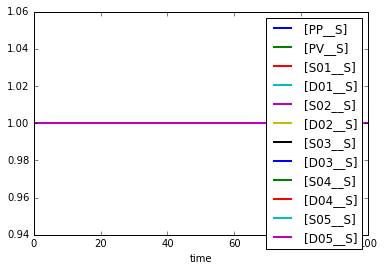

In [3]:
# flow model
sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_flow_Nc5_v3.xml')

# pressure model
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc5_v3.xml')

r = te.loads(sbml_path)
r.integrator.absolute_tolerance = 1E-20
r.integrator.variable_step_size = True

# print(r.getAntimony(current=False))
r.timeCourseSelections = ['time'] + ['[{}]'.format(sid) for sid in (r.getBoundarySpeciesIds() + r.getFloatingSpeciesIds()) if '__S' in sid]
import pprint
pprint.pprint(sorted(r.timeCourseSelections))
r.resetToOrigin()
s = r.simulate(0,100)
r.plot(s);

(0, 5)

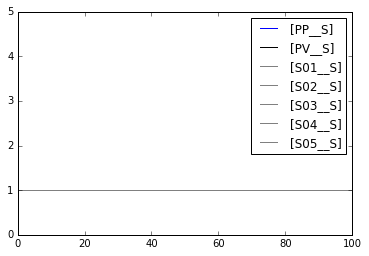

In [4]:
plt.plot(s['time'], s['[PP__S]'], color='blue', label='[PP__S]')
plt.plot(s['time'], s['[PV__S]'], color='black', label='[PV__S]')
for k in range(int(r.Nc)):
    label = '[S{:02}__S]'.format(k+1)
    plt.plot(s['time'], s[label], color='gray', label=label)
plt.legend()
plt.ylim([0,5])

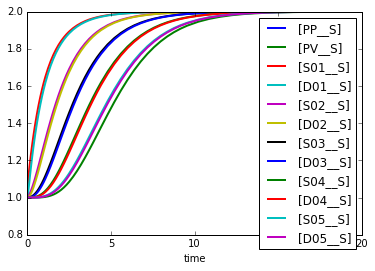

In [12]:
r.resetToOrigin()
r['[PP__S]'] = 2

s = r.simulate(0,20)
r.plot(s);

In [ ]:
plt.plot()

Plot the concentration front over time

In [13]:
import numpy as np

In [14]:
r.timeCourseSelections

['time',
 '[PP__S]',
 '[PV__S]',
 '[S01__S]',
 '[D01__S]',
 '[S02__S]',
 '[D02__S]',
 '[S03__S]',
 '[D03__S]',
 '[S04__S]',
 '[D04__S]',
 '[S05__S]',
 '[D05__S]']

In [18]:
import multiscale


def getPPIndex()

s[:, [1,2]]

 [[ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2,       1],
  [ 2, 1.00001],
  [ 2, 1.00001],
  [ 2, 1.00001],
  [ 2, 1.00002],
  [ 2, 1.00003],
  [ 2, 1.00005],
  [ 2, 1.00009],
  [ 2, 1.00015],
  [ 2, 1.00025],
  [ 2, 1.00038],
  [ 2, 1.00056],
  [ 2, 1.00099],
  [ 2, 1.00164],
  [ 2, 1.00255],
  [ 2, 1.00379],
  [ 2, 1.00656],
  [ 2, 1.01053],
  [ 2,  1.0159],
  [ 2, 1.02285],
  [ 2, 1.03152],
  [ 2, 1.04202],
  [ 2, 1.05439],
  [ 2, 1.06864],
  [ 2, 1.08474],
  [ 2, 1.11238],
  [ 2,  1.1437],
  [ 2, 1.17824],
  [ 2, 1.21541],
  [ 2, 1.25462],
  [ 2, 1.29525],
  [ 2, 1.33672],
  [ 2, 1.37846